In [1]:
import warnings
warnings.filterwarnings('ignore') # For better visibility, warnings are turned off in this notebook

# FINE.district Example

In this application of the FINE framework, an energy supply system for a residential district 
with a district electricity and heating grid is modeled and optimized.

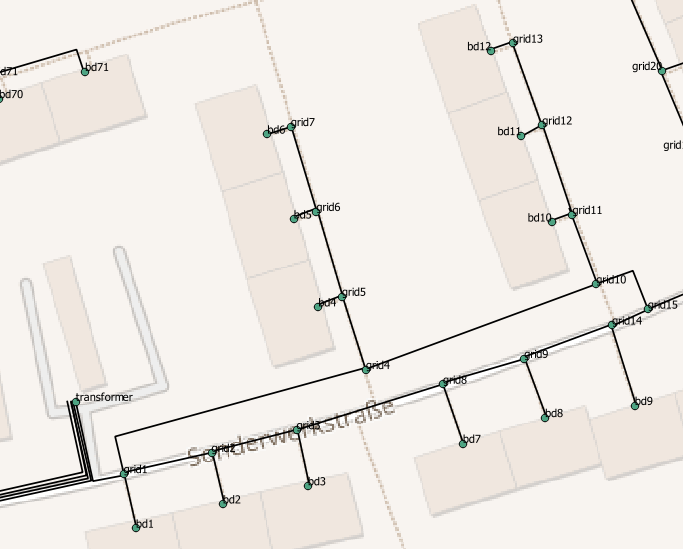

In [2]:
from IPython.display import Image
Image("img/plan.png")

The workflow is structures as follows:
-  Required packages are imported and paths to input data are set
-  Data paths are set and the scenario is defined
-  An energy system model instance is created
-  Commodity sources are added to the energy supply system model
-  Commodity storages are added to the energy supply system model
-  Commodity transmission components are added to the energy supply system model
-  Commodity conversion components are added to the energy supply system model
-  Commodity sinks are added to the energy supply system model
-  The energy supply system model is optimized
-  Selected optimization results are presented

## Import required packages and set data paths

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [3]:
import os
import FINE as fn
import pandas as pd

## Set scenario and data paths

In [4]:
FILE_PATH = os.getcwd()

#get the input data path
techPath = os.path.join(FILE_PATH,'data','0_TechnoEconomicData')
TECH_PATH = techPath

scenario = 'Example'
LN = 'ONSALL'
pathway = '8_AllTechnologies'
inputDataName = '8_AllTechnologies'
heatYear= '2020'
typs = 12
numberOfTimeSteps = 8760

scenarioName =scenario +'_' + pathway +'_'+ heatYear +'_' + str(typs) 

#Paths
gridPath = os.path.join(FILE_PATH,'data','3_Grid',LN)
regionPath = os.path.join(FILE_PATH,'data','1_Regions',LN)
availibilityPath = os.path.join(FILE_PATH,'data','5_Pathways',pathway)
generationProfilePath = os.path.join(FILE_PATH,'data','4_GenerationProfiles',LN)
loadProfilePath = os.path.join(FILE_PATH,'data','2_LoadProfiles',LN)
resultPath = os.path.join(os.getcwd(),"results", scenarioName)

#result folder
if not os.path.exists(resultPath):
    os.makedirs(resultPath)
    
#Define carrier and regions
carriers= set(pd.read_excel(os.path.join(TECH_PATH, 'Carrier.xlsx')))
regions = set(pd.read_excel(os.path.join(regionPath, 'Regions.xlsx')))

commodityUnitsDict = dict.fromkeys(carriers, 'kW')

In [5]:
carriers

{'BatteryElec',
 'CO2',
 'DomElec',
 'GridElec',
 'GridHeat',
 'Heat',
 'HotWater',
 'NaturalGas',
 'NaturalGasGrid',
 'PVElec'}

## Initialize energy system model instance 

The structure of the energy supply system model is given by the considered locations, 
commodities, the number of time steps as well as the hours per time step.

In [6]:
esM = fn.EnergySystemModel(locations=regions, commodities=carriers, 
                           commodityUnitsDict=commodityUnitsDict, costUnit='Euro', 
                           lengthUnit='km', numberOfTimeSteps=numberOfTimeSteps, hoursPerTimeStep=1)

## Add source components 

Source components generate commodities across the energy system's virtual boundaries.

In [7]:
gen_df = pd.read_excel(os.path.join(TECH_PATH, 'Generation_Technologies2020.xlsx'),
                                    index_col='id')
gen_kwgs=gen_df.to_dict('index')
gen_maxCap = pd.read_excel(os.path.join(generationProfilePath, 'GenerationCapacities.xlsx'),
                                    sheet_name='GenerationCapacities', index_col=0)
gen_df_elig = pd.read_excel(os.path.join(availibilityPath, 'Generation_Availability.xlsx'),
                                        sheet_name='Availability', index_col=0)

for i in gen_kwgs.keys():
    if not gen_maxCap.T[i].isna().any():
        print('Building ' + i + ' ...')
        #PV generation capacity factors in south and north orientation
        maxGeneration = pd.read_excel(os.path.join(generationProfilePath, 'Generation_Profiles.xlsx'), sheet_name = i)
        esM.add(fn.Source(esM=esM, hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, 
                          operationRateMax=maxGeneration, capacityMax=gen_maxCap.T[i], 
                          locationalEligibility=gen_df_elig.T[i],  
                          **gen_kwgs[i]))
        

Building PV1 ...
Building PV2 ...


In [8]:
purchaseElectricity = pd.read_excel(os.path.join(TECH_PATH,'purchaseElectricity.xlsx'), index_col=0)

esM.add(fn.Source(esM=esM, name='Electricity purchase', commodity='GridElec', 
                  hasCapacityVariable=False, operationRateMax=purchaseElectricity, 
                  opexPerOperation=0.0001))

purchaseNG = pd.read_excel(os.path.join(TECH_PATH,'purchaseNaturalGas.xlsx'), index_col=0)

esM.add(fn.Source(esM=esM, name='NaturalGas purchase', commodity='NaturalGasGrid', 
                  hasCapacityVariable=False, operationRateMax=purchaseNG, opexPerOperation=0))

## Add storage components

Storage components can store commodities across time steps.

The self discharge of a storage technology is described in FINE in percent per hour. If the 
literature value is given in percent per month, e.g. 3%/month, the self discharge per hours is 
obtained using the equation
(1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [9]:
st_df = pd.read_excel(os.path.join(TECH_PATH, 'Storage_Technologies2020.xlsx'), index_col='id')
st_kwgs=st_df.to_dict('index')
st_df_elig = pd.read_excel(os.path.join(availibilityPath, 'Storage_Availability.xlsx'), 
                           sheet_name='Availability', index_col=0)
st_df_max = pd.read_excel(os.path.join(TECH_PATH, 'Storage_Technologies2020.xlsx'), 
                          sheet_name='MaxCap', index_col=0)

for i in st_kwgs.keys():
    if st_df_max.T[i].isnull().any():
        print('Initializing ' + i + ' ...')
        esM.add(fn.Storage(esM=esM, hasCapacityVariable=True, 
                           locationalEligibility=st_df_elig.T[i], hasIsBuiltBinaryVariable=True, 
                           **st_kwgs[i]))
    else:
        esM.add(fn.Storage(esM=esM, hasCapacityVariable=True, capacityMax=st_df_max.T[i],
                           locationalEligibility=st_df_elig.T[i], hasIsBuiltBinaryVariable=True, 
                           **st_kwgs[i]))
        

Initializing Thermal Storage_Big ...
Initializing Battery_Big ...


## Add transmission components

Transmission components transmit commodities between buildings.

In [10]:
fixCapacity = pd.read_excel(os.path.join(gridPath,'grid_capacity_matrix.xlsx'), index_col=0)
E_GridLength = pd.read_excel(os.path.join(gridPath, 'grid_length_matrix.xlsx'), index_col=0)
availCapacity = pd.read_excel(os.path.join(gridPath, 'grid_availability_matrix.xlsx'), index_col=0)

print('Initializing electricity grid ...')
esM.add(fn.Transmission(esM=esM, name='E_Distribution-Grid', commodity='GridElec', 
                        hasCapacityVariable=True, locationalEligibility=availCapacity, 
                        distances=E_GridLength, capacityFix=fixCapacity,
                        economicLifetime=50, interestRate=0.04, losses=0.00001, 
                        ))

Initializing electricity grid ...


In [11]:
fixCapacity = pd.read_excel(os.path.join(gridPath, 'grid_capacity_matrix.xlsx'), index_col=0)
NG_GridLength = pd.read_excel(os.path.join(gridPath, 'grid_length_matrix.xlsx'), index_col=0)
availCapacityNG = pd.read_excel(os.path.join(gridPath, 'grid_availability_matrix.xlsx'), index_col=0)

print('Initializing natural gas grid ...')
esM.add(fn.Transmission(esM=esM, name='NG_Distribution_Grid', commodity='NaturalGasGrid', 
                        hasCapacityVariable=False, 
                        economicLifetime=50, interestRate=0.04, losses=0.00001, 
                        distances=NG_GridLength, locationalEligibility=availCapacityNG))

Initializing natural gas grid ...


In [12]:
dh_gridLength = pd.read_excel(os.path.join(gridPath, 'dH_grid_length_matrix.xlsx'), index_col=0)
dh_elig = pd.read_excel(os.path.join(gridPath, 'dH_grid_availability_matrix.xlsx'), index_col=0)

print('Initializing district heating network ...')
esM.add(fn.Transmission(esM=esM, name='DH_Distribution_Grid_medium', commodity='GridHeat', 
                        hasCapacityVariable=True, 
                        economicLifetime=40, interestRate=0.025, losses=0.000031, 
                        hasIsBuiltBinaryVariable=True, investIfBuilt=455, opexIfBuilt=4.55, 
                        locationalEligibility=dh_elig, bigM=2010, distances=dh_gridLength))

Initializing district heating network ...


## Add Conversion components

Conversion components convert m commodities into n other commodities.

In [13]:
cv_df = pd.read_excel(os.path.join(TECH_PATH, 'Conversion_Technologies'+ str(heatYear)+'.xlsx'), 
                      index_col='id')
cv_kwgs = cv_df.to_dict('index')
cv_df_max = pd.read_excel(os.path.join(TECH_PATH, 'Conversion_Technologies'+ str(heatYear)+'.xlsx'), 
                          sheet_name='MaxCap', index_col=0)
cv_df_elig = pd.read_excel(os.path.join(availibilityPath, 'Conversion_Availability.xlsx'), 
                           sheet_name='Availability', index_col=0)

for i in cv_kwgs.keys():
    cv_df_cvFactor = pd.read_excel(os.path.join(TECH_PATH, 'Conversion_Factors.xlsx'),
                                   sheet_name=i, index_col=0)
    cv_df_cvFactor=cv_df_cvFactor['Conversion factor']
    if not cv_df_elig.T[i].isin([0,0]).all():
        if cv_df_max.T[i].isna().any():
            print('Initializing ' + i + ' ...') 
            esM.add(fn.Conversion(esM=esM, physicalUnit='kW', locationalEligibility=cv_df_elig.T[i], 
                                  hasCapacityVariable=True, 
                                  commodityConversionFactors=cv_df_cvFactor, 
                                  hasIsBuiltBinaryVariable= cv_kwgs[i]['investIfBuilt'] is not 0, 
                                  **cv_kwgs[i]))
        else:
            print('Initializing ' + i + ' ...') 
            esM.add(fn.Conversion(esM=esM, physicalUnit='kW', locationalEligibility=cv_df_elig.T[i], 
                                  hasCapacityVariable=True, capacityMax=cv_df_max.T[i], 
                                  commodityConversionFactors=cv_df_cvFactor, 
                                  hasIsBuiltBinaryVariable= cv_kwgs[i]['investIfBuilt'] is not 0, 
                                  **cv_kwgs[i]))
            

Initializing Boiler ...
Initializing Heat Pump ...
Initializing SOFC ...
Initializing CHP ...
Initializing CHP_Big ...
Initializing Electric Heater ...
Initializing PV_Bat ...
Initializing PV_Dom ...
Initializing Bat_Dom ...
Initializing GridDom ...
Initializing DomGrid ...
Initializing NgGridDom ...
Initializing HeatHW ...
Initializing GridHeat ...


## Add sink components

Electricity, heat and hot water demand

In [14]:
demand = pd.read_excel(os.path.join(loadProfilePath, 'ElectricityDemandProfiles2020_Final.xlsx'))

esM.add(fn.Sink(esM=esM, name='BuildingsElectr', commodity='DomElec', hasCapacityVariable=False, 
operationRateFix=demand))

demandH = pd.read_excel(os.path.join(loadProfilePath, 'HeatDemandProfiles'+ heatYear + '_Final'+'.xlsx'))

esM.add(fn.Sink(esM=esM, name='BuildingsHeat', commodity='Heat', hasCapacityVariable=False, 
operationRateFix=demandH))

demandHW = pd.read_excel(os.path.join(loadProfilePath, 'HotWaterDemandProfiles2020_Final.xlsx'))

esM.add(fn.Sink(esM=esM, name='BuildingHotWater', commodity='HotWater', hasCapacityVariable=False, 
operationRateFix=demandHW))

In [15]:
saleElectricity = pd.read_excel(os.path.join(TECH_PATH,'SaleElectricity.xlsx'), index_col=0)

esM.add(fn.Sink(esM=esM, name='Electricity Sale', commodity='GridElec', 
                  hasCapacityVariable=False, operationRateMax=saleElectricity, opexPerOperation=0.0001))

## Time series aggregation and optimization

In [16]:
esM.cluster(numberOfTypicalPeriods=typs)

esM.optimize(timeSeriesAggregation=True, optimizationSpecs='cuts=0 method=2')
# esM.optimize(timeSeriesAggregation=True, solver='gurobi', 
#              optimizationSpecs='Method=2 NodeMethod=1 ScaleFlag=1 Cuts=2 MipFocus=2')


Clustering time series data with 12 typical periods and 24 time steps per period...
		(16.9754 sec)

Time series aggregation specifications:
Number of typical periods:12, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.5185 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(3.4396 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8600 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.2110 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(10.0333 sec)

Declaring objective function...
		(0.8230 sec)

Academic license - for non-commercial 

  114889    2.4232552e+05   0.000000e+00   0.000000e+00    108s

Root relaxation: objective 2.423255e+05, 114889 iterations, 105.82 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 242325.521    0   30          - 242325.521      -     -  109s
H    0     0                    245930.53289 242325.521  1.47%     -  109s
     0     0 242325.521    0   30 245930.533 242325.521  1.47%     -  113s
     0     2 242325.521    0   30 245930.533 242325.521  1.47%     -  120s
     9     2     cutoff    5      245930.533 243719.562  0.90%   387  125s
H   11     2                    245930.30257 243761.347  0.88%   320  129s
H   14     2                    245930.26854 244132.109  0.73%   499  129s
    15     2 244611.321    8   22 245930.269 244342.713  0.65%   562  131s
H   19     2                    245930.26275 244899.629  0.42%   471  132s
H   23     2                    2

## Output of selected results

For the assessment of the optimization result, several result output functions are available. 
They can be categorized into output in form of tables, time series visualization or 
geo-referenced output visualization.

In [17]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)


bd1     bd10     bd11  \
Component            Property     Unit                                  
BuildingHotWater     operation    [kW*h/a]  15965.4  14707.4  15181.3   
BuildingsElectr      operation    [kW*h/a]  20858.1  20740.2  23383.1   
BuildingsHeat        operation    [kW*h/a]  92305.2  94200.1  89689.2   
Electricity purchase TAC          [Euro/a]        0        0        0   
                     operation    [kW*h/a]      NaN      NaN      NaN   
                     opexOp       [Euro/a]      NaN      NaN      NaN   
PV1                  TAC          [Euro/a]  1361.29  1397.95  1329.24   
                     capacity     [kW]      13.8176  14.2103  13.4741   
                     capexCap     [Euro/a]  1109.88  1141.43  1082.29   
                     capexIfBuilt [Euro/a]  61.7873  61.7873  61.7873   
                     invest       [Euro]    18962.8  19473.5  18516.3   
                     isBuilt      [-]             1        1        1   
                     operation    [kW*h/a]  10764.5  13225.3    12672   
                     opexCap      [Euro/a]  179.628  184.735  175.163   
                     opexIfBuilt  [Euro/a]       10       10       10   
PV2                  TAC          [Euro/a]  1361.64  922.222  1126.77   
                     capacity     [kW]      13.8214  9.11276  11.3046   
                     capexCap     [Euro/a]  1110.18  731.969  908.023   
                     capexIfBuilt [Euro/a]  61.7873  61.7873  61.7873   
                     invest       [Euro]    18967.8  12846.6  15695.9   
                     isBuilt      [-]             1        1        1   
                     operation    [kW*h/a]  9584.13  4811.28  5968.25   
                     opexCap      [Euro/a]  179.678  118.466  146.959   
                     opexIfBuilt  [Euro/a]       10       10       10   

                                               bd12      bd2      bd3  \
Component            Property     Unit                                  
BuildingHotWater     operation    [kW*h/a]    15627  15053.6  15392.2   
BuildingsElectr      operation    [kW*h/a]  22646.2  21259.7  22812.8   
BuildingsHeat        operation    [kW*h/a]  88762.6    89479  88859.9   
Electricity purchase TAC          [Euro/a]        0        0        0   
                     operation    [kW*h/a]      NaN      NaN      NaN   
                     opexOp       [Euro/a]      NaN      NaN      NaN   
PV1                  TAC          [Euro/a]  1309.45  1316.35  1306.54   
                     capacity     [kW]      13.2621   13.336  13.2309   
                     capexCap     [Euro/a]  1065.26  1071.19  1062.75   
                     capexIfBuilt [Euro/a]  61.7873  61.7873  61.7873   
                     invest       [Euro]    18240.7  18336.8  18200.1   
                     isBuilt      [-]             1        1        1   
                     operation    [kW*h/a]  11863.2    10253  10498.6   
                     opexCap      [Euro/a]  172.407  173.368  172.001   
                     opexIfBuilt  [Euro/a]       10       10       10   
PV2                  TAC          [Euro/a]  891.857  1312.98  1310.22   
                     capacity     [kW]      8.78739  13.2999  13.2703   
                     capexCap     [Euro/a]  705.834  1068.29  1065.92   
                     capexIfBuilt [Euro/a]  61.7873  61.7873  61.7873   
                     invest       [Euro]    12423.6  18289.8  18251.4   
                     isBuilt      [-]             1        1        1   
                     operation    [kW*h/a]  4638.84  8909.66  8790.61   
                     opexCap      [Euro/a]  114.236  172.898  172.514   
                     opexIfBuilt  [Euro/a]       10       10       10   

                                                bd4      bd5      bd6  \
Component            Property     Unit                                  
BuildingHotWater     operation    [kW*h/a]  16110.6  13350.3  15176.5   
BuildingsElectr      operation 

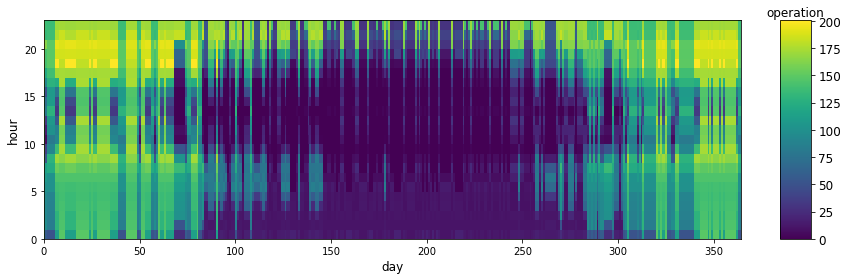

In [18]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity purchase', 'transformer')

In [19]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

bd1     bd10     bd11     bd12      bd2  \
Component Property     Unit                                                    
Bat_Dom   capacity     [kW]           13       13       13       12       12   
          operation    [kW*h/a]  12800.5  14956.9  15708.1    14260  12337.6   
DomGrid   capacity     [kW]           12       12       11        4       12   
          operation    [kW*h/a]  2251.85  1229.95  1096.76  187.281  1636.68   
GridDom   TAC          [Euro/a]  16343.4  16768.3  16767.3  16831.7  16100.2   
          capacity     [kW]           20       19       22       19       24   
          operation    [kW*h/a]  54696.8  56118.8  56115.6  56331.1    53883   
          opexOp       [Euro/a]  16343.4  16768.3  16767.3  16831.7  16100.2   
Heat Pump TAC          [Euro/a]  1378.19  1409.79  1389.06  1381.14  1394.28   
          capacity     [kW]      22.6453  23.3557  22.8898  22.7117   23.007   
          capexCap     [Euro/a]   871.58   898.92  880.989  874.136  885.501   
          capexIfBuilt [Euro/a]  320.736  320.736  320.736  320.736  320.736   
          invest       [Euro]    18587.2  19013.4  18733.9    18627  18804.2   
          isBuilt      [-]             1        1        1        1        1   
          operation    [kW*h/a]   110033   110562   106517   105931   106249   
          opexCap      [Euro/a]  135.872  140.134  137.339   136.27  138.042   
          opexIfBuilt  [Euro/a]       50       50       50       50       50   
HeatHW    capacity     [kW]            9       12       12       12       11   
          operation    [kW*h/a]  15965.4  14707.4  15181.3    15627  15053.6   
PV_Bat    capacity     [kW]           13       13       13       12       12   
          operation    [kW*h/a]  12800.5  14956.9  15708.1    14260  12337.6   
PV_Dom    capacity     [kW]           17       15       15       13       16   
          operation    [kW*h/a]  7548.14  3079.67  2932.18  2242.09  6825.07   

                                     bd3      bd4      bd5      bd6      bd7  \
Component Property     Unit                                                    
Bat_Dom   capacity     [kW]           12       13       11       12       12   
          operation    [kW*h/a]  13343.1  15686.2  10760.5  14301.1  12314.8   
DomGrid   capacity     [kW]           14       12        9        8       15   
          operation    [kW*h/a]  1456.09  1220.81  334.773  345.489  1881.36   
GridDom   TAC          [Euro/a]  16415.5  16604.9  17122.6  15841.8  16316.7   
          capacity     [kW]           20       20       19       18       21   
          operation    [kW*h/a]  54938.2  55572.1  57304.4  53017.9  54607.4   
          opexOp       [Euro/a]  16415.5  16604.9  17122.6  15841.8  16316.7   
Heat Pump TAC          [Euro/a]  1337.75  1410.33  1376.91  1341.53  1354.86   
          capacity     [kW]      21.7365  23.3678  22.6166  21.8214   22.121   
          capexCap     [Euro/a]    836.6  899.386  870.472  839.869  851.399   
          capexIfBuilt [Euro/a]  320.736  320.736  320.736  320.736  320.736   
          invest       [Euro]    18041.9  19020.7  18569.9  18092.9  18272.6   
          isBuilt      [-]             1        1        1        1        1   
          operation    [kW*h/a]   105844   111135   102954   102965   105102   
          opexCap      [Euro/a]  130.419  140.207  135.699  130.929  132.726   
          opexIfBuilt  [Euro/a]       50       50       50       50       50   
HeatHW    capacity     [kW]            9       12       10       10        9   
          operation    [kW*h/a]  15392.2  16110.6  13350.3  15176.5  15770.6   
PV_Bat    capacity     [kW]           12       13       11       12       12   
          operation    [kW*h/a]  13343.1  15686.2  10760.5  14301.1  12314.8   
PV_Dom    capacity     [kW]           16       15       11       13       16   
          operation    [kW*h/a]   5946.1  3530.26  1956.08  2310.03  7098.37   

                                 ..

In [20]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

bd1     bd10     bd11  \
Component       Property           Unit                                  
Thermal Storage TAC                [Euro/a]  218.286  209.557  209.834   
                capacity           [kW*h]    117.611  112.881  113.031   
                capexCap           [Euro/a]  217.038  208.308  208.586   
                capexIfBuilt       [Euro/a]  1.24835  1.24835  1.24835   
                invest             [Euro]    4021.79  3860.95  3866.07   
                isBuilt            [-]             1        1        1   
                operationCharge    [kW*h/a]   983245   935063   949613   
                operationDischarge [kW*h/a]   981483   933409   947966   

                                                bd12      bd2      bd3  \
Component       Property           Unit                                  
Thermal Storage TAC                [Euro/a]  211.414    214.6  212.126   
                capacity           [kW*h]    113.887  115.614  114.273   
                capexCap           [Euro/a]  210.166  213.352  210.878   
                capexIfBuilt       [Euro/a]  1.24835  1.24835  1.24835   
                invest             [Euro]    3895.17  3953.88  3908.29   
                isBuilt            [-]             1        1        1   
                operationCharge    [kW*h/a]   938499   959788   950211   
                operationDischarge [kW*h/a]   936957   958072   948619   

                                                 bd4      bd5      bd6  \
Component       Property           Unit                                  
Thermal Storage TAC                [Euro/a]  197.543  136.901  181.243   
                capacity           [kW*h]    106.371  73.5094   97.538   
                capexCap           [Euro/a]  196.295  135.653  179.995   
                capexIfBuilt       [Euro/a]  1.24835  1.24835  1.24835   
                invest             [Euro]    3639.61  2522.32  3339.29   
                isBuilt            [-]             1        1        1   
                operationCharge    [kW*h/a]   881852   599714   820337   
                operationDischarge [kW*h/a]   880329   598861   818888   

                                                 bd7  ... grid15 grid2 grid3  \
Component       Property           Unit               ...                      
Thermal Storage TAC                [Euro/a]  205.858  ...      0     0     0   
                capacity           [kW*h]    110.876  ...    NaN   NaN   NaN   
                capexCap           [Euro/a]  204.609  ...    NaN   NaN   NaN   
                capexIfBuilt       [Euro/a]  1.24835  ...    NaN   NaN   NaN   
                invest             [Euro]     3792.8  ...    NaN   NaN   NaN   
                isBuilt            [-]             1  ...    NaN   NaN   NaN   
                operationCharge    [kW*h/a]   907578  ...    NaN   NaN   NaN   
                operationDischarge [kW*h/a]   906000  ...    NaN   NaN   NaN   

                                            grid4 grid5 grid6 grid7 grid8  \
Component       Property           Unit                                     
Thermal Storage TAC                [Euro/a]     0     0     0     0     0   
                capacity           [kW*h]     NaN   NaN   NaN   NaN   NaN   
                capexCap           [Euro/a]   NaN   NaN   NaN   NaN   NaN   
                capexIfBuilt       [Euro/a]   NaN   NaN   NaN   NaN   NaN   
                invest             [Euro]     NaN   NaN   NaN   NaN   NaN   
                isBuilt            [-]        NaN   NaN   NaN   NaN   NaN   
                operationCharge    [kW*h/a]   NaN   NaN   NaN   NaN   NaN   
                operationDischarge [kW*h/a]   NaN   NaN   NaN   NaN   NaN   

                                            grid9 transformer  
Component       Property           Unit                        
Thermal Storage TAC                [Euro/a]     0           0  
                capacity           [kW*h]     NaN           0 

In [21]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

bd1         bd10  \
Component           Property  Unit     LocationIn                              
E_Distribution-Grid capacity  [kW]     bd1                  NaN          NaN   
                                       bd10                 NaN          NaN   
                                       bd11                 NaN          NaN   
                                       bd12                 NaN          NaN   
                                       bd2                  NaN          NaN   
                                       bd3                  NaN          NaN   
                                       bd4                  NaN          NaN   
                                       bd5                  NaN          NaN   
                                       bd6                  NaN          NaN   
                                       bd7                  NaN          NaN   
                                       bd8                  NaN          NaN   
                                       bd9                  NaN          NaN   
                                       grid1              20000          NaN   
                                       grid10               NaN          NaN   
                                       grid11               NaN        20000   
                                       grid12               NaN          NaN   
                                       grid13               NaN          NaN   
                                       grid14               NaN          NaN   
                                       grid15               NaN          NaN   
                                       grid2                NaN          NaN   
                                       grid3                NaN          NaN   
                                       grid4                NaN          NaN   
                                       grid5                NaN          NaN   
                                       grid6                NaN          NaN   
                                       grid7                NaN          NaN   
                                       grid8                NaN          NaN   
                                       grid9                NaN          NaN   
                                       transformer          NaN          NaN   
                    operation [kW*h/a] bd1                  NaN          NaN   
                                       bd10                 NaN          NaN   
                                       bd11                 NaN          NaN   
                                       bd12                 NaN          NaN   
                                       bd2                  NaN          NaN   
                                       bd3                  NaN          NaN   
                                       bd4                  NaN          NaN   
                                       bd5                  NaN          NaN   
                                       bd6                  NaN          NaN   
                                       bd7                  NaN          NaN   
                                       bd8                  NaN          NaN   
                                       bd9                  NaN          NaN   
                                       grid1        2.15418e+06          NaN   
                                       grid10               NaN          NaN   
                                       grid11               NaN  3.32557e+06   
                                       grid12               NaN          NaN   
                                       grid13               NaN          NaN   
                                       grid14               NaN          NaN   
                                       grid15               NaN          NaN   
                                       grid2                NaN          NaN   
                                       grid3                